<a href="https://colab.research.google.com/github/salmanromeo/ECEN_5513_Stochastic_Systems/blob/main/PSD_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**10.34**

#####(a) Create a random process $X[n]$ where each sample of the random process is an IID, Bernoulli random variable equally likely to be $±1$. Form a new process according to the AR(2) model $Y[n]=(1/2)Y[n-1]-(1/4)Y[n-2]+X[n]$. Assume for $Y[n]=0$ for $n<0$.

#####(b) Compute the time-average autocorrelation function $<Y[n]Y[n+k]>$ from a single realization of this process.

#####(c) Compute the ensemble average autocorrelation function $E[Y[n]Y[n+k]]$ from several realizations of this process. Does the process appear to be ergodic in the autocorrelation?
#####(d) Estimate the PSD of this process using the periodogram method.

**10.35**

#####(a) For the process in Exercise 10.34, find a parametric estimate of the PSD by using an AR(1) model. Compare the resulting PSD estimate with the non-parametric estimate found in Exercise 10.34(d). Explain any differences you see.

#####(b) Again, referring to the process in Exercise 10.34, find a parametric estimate of the PSD this time using an AR(2) model. Compare the resulting PSD estimate with the non-parametric estimate found in Exercise 10.34(d). Explain any differences you see.

<ipython-input-175-cea28063233c>:45: RuntimeWarning: invalid value encountered in arccosh
  R_YY_ar1 = sigma**2 / (1 - rho**2) * np.exp(-np.arange(N) * np.arccosh(np.abs(rho))**2 / 2)
<ipython-input-175-cea28063233c>:55: RuntimeWarning: invalid value encountered in log
  return -np.sum(np.log(R_YY_ar2[:N]) + data / R_YY_ar2[:N])


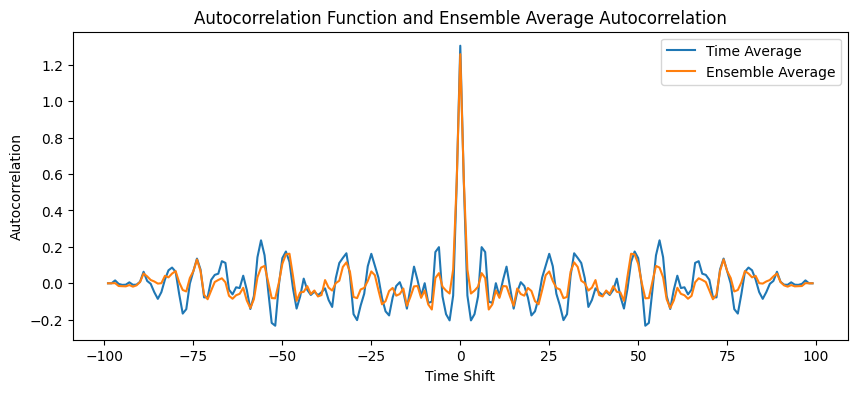

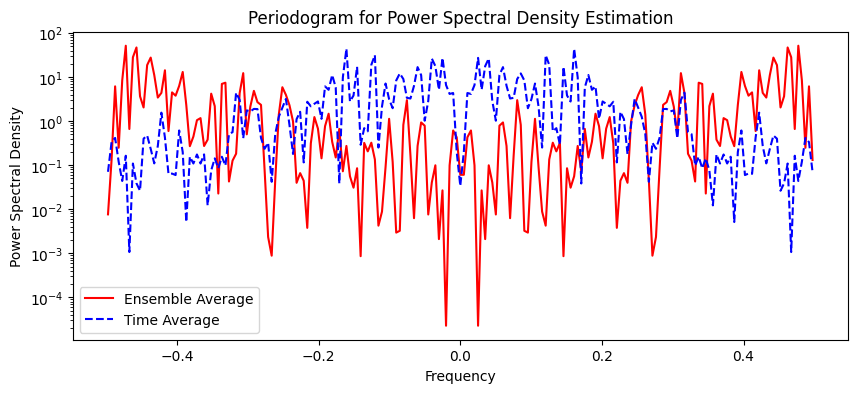

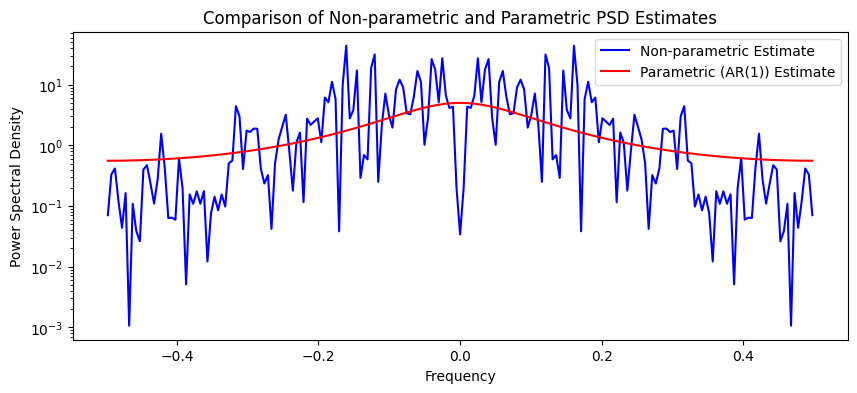

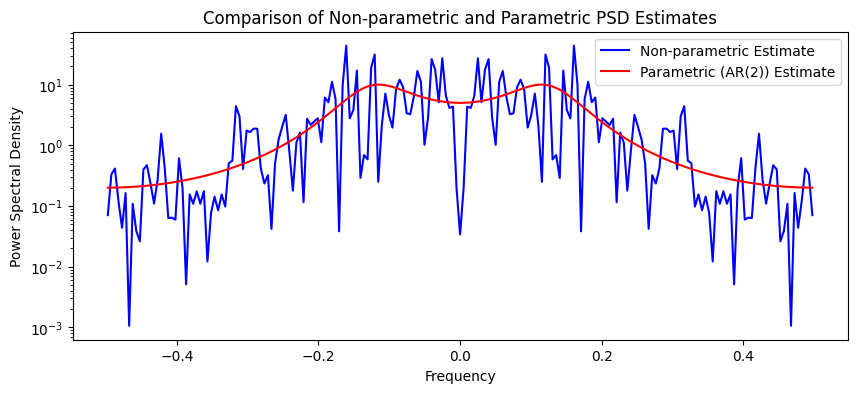

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Parameters
num_realizations = 2  # Number of realizations
num_samples = 100  # Number of samples per realization
a1 = 1/2
a2 = -1/4
order_ar2 = 2  # Order of the AR(2) model

# Initialize arrays to store autocorrelation functions and power spectral densities
ensemble_R_YY = np.zeros((num_realizations, 2*num_samples - 1))
ensemble_PSD_nonparametric = np.zeros((num_realizations, 2*num_samples - 1))
ensemble_PSD_parametric_ar1 = np.zeros((num_realizations, 2*num_samples - 1))
ensemble_PSD_parametric_ar2 = np.zeros((num_realizations, 2*num_samples - 1))

# Perform multiple realizations
for realization in range(num_realizations):
    # Generate random process X[n] (Bernoulli random variable)
    X = np.random.choice([-1, 1], size=num_samples)

    # Initialize Y[n] with zeros
    Y = np.zeros(num_samples)

    # AR(2) recursion
    for n in range(2, num_samples):
        Y[n] = (1/2)*Y[n-1] - (1/4)*Y[n-2] + X[n]

    # Compute autocorrelation function R_YY[k] for the realization
    R_YY = np.correlate(Y, Y, mode='full') / num_samples

    # Store the autocorrelation function for the realization
    ensemble_R_YY[realization, :] = R_YY

    # Compute the non-parametric power spectral density using the periodogram
    PSD_nonparametric = np.abs(np.fft.fft(R_YY)) ** 2
    ensemble_PSD_nonparametric[realization, :] = PSD_nonparametric

    # Fit an AR(1) model to the data and compute parametric PSD estimate
    def ar1_neg_log_likelihood(params, data):
        rho = params[0]
        sigma = params[1]
        N = len(data)
        R_YY_ar1 = sigma**2 / (1 - rho**2) * np.exp(-np.arange(N) * np.arccosh(np.abs(rho))**2 / 2)
        return -np.sum(np.log(R_YY_ar1[:N]) + data / R_YY_ar1[:N])

    # Fit an AR(2) model to the data and compute parametric PSD estimate
    def ar2_neg_log_likelihood(params, data):
        a1 = params[0]
        a2 = params[1]
        sigma = params[2]
        N = len(data)
        R_YY_ar2 = sigma**2 / (1 - a1**2 - a2**2) * np.exp(-np.arange(N) * np.arccosh((a1 + a2) / (1 + a1 * a2))**2 / 2)
        return -np.sum(np.log(R_YY_ar2[:N]) + data / R_YY_ar2[:N])

    # Initial guess for parameters
    initial_params_ar1 = [0.5, np.std(Y)]
    initial_params_ar2 = [1, -0.5, np.std(Y)]

    # Minimize negative log-likelihood to obtain AR(1) model parameters
    result_ar1 = minimize(ar1_neg_log_likelihood, initial_params_ar1, args=(R_YY,), method='L-BFGS-B')
    rho_optimal, sigma_optimal_ar1 = result_ar1.x

    # Minimize negative log-likelihood to obtain AR(2) model parameters
    result_ar2 = minimize(ar2_neg_log_likelihood, initial_params_ar2, args=(R_YY,), method='L-BFGS-B')
    a1_optimal, a2_optimal, sigma_optimal_ar2 = result_ar2.x

    # Compute parametric PSD estimate using AR(1) model parameters
    PSD_parametric_ar1 = sigma_optimal_ar1**2 / np.abs(1 - rho_optimal * np.exp(-2j * np.pi * np.fft.fftfreq(len(R_YY))))**2
    ensemble_PSD_parametric_ar1[realization, :] = PSD_parametric_ar1

    # Compute parametric PSD estimate using AR(2) model parameters
    PSD_parametric_ar2 = sigma_optimal_ar2**2 / np.abs(1 - a1_optimal * np.exp(-2j * np.pi * np.fft.fftfreq(len(R_YY)))
                                                - a2_optimal * np.exp(-4j * np.pi * np.fft.fftfreq(len(R_YY))))**2
    ensemble_PSD_parametric_ar2[realization, :] = PSD_parametric_ar2

# Compute ensemble average power spectral densities
avg_R_YY = np.mean(ensemble_R_YY, axis=0)
avg_PSD_nonparametric = np.mean(ensemble_PSD_nonparametric, axis=0)
avg_PSD_parametric_ar1 = np.mean(ensemble_PSD_parametric_ar1, axis=0)
avg_PSD_parametric_ar2 = np.mean(ensemble_PSD_parametric_ar2, axis=0)

# Frequency values corresponding to the FFT result
freq_values = np.fft.fftfreq(len(R_YY), d=1)

# Shift frequencies to be centered at zero
freq_values_shifted = np.fft.fftshift(freq_values)
avg_PSD_nonparametric_shifted = np.fft.fftshift(avg_PSD_nonparametric)
avg_PSD_parametric_shifted_ar1 = np.fft.fftshift(avg_PSD_parametric_ar1)
avg_PSD_parametric_shifted_ar2 = np.fft.fftshift(avg_PSD_parametric_ar2)

# Plot both autocorrelation functions
k_values = np.arange(-num_samples + 1, num_samples)
plt.figure(figsize=(10, 4))
plt.plot(k_values, R_YY, label='Time Average')
plt.plot(k_values, avg_R_YY, label='Ensemble Average')
plt.title('Autocorrelation Function and Ensemble Average Autocorrelation')
plt.xlabel('Time Shift')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

# Plot the periodogram
plt.figure(figsize=(10, 4))
plt.semilogy(freq_values_shifted, ensemble_PSD_nonparametric[0, :], 'r-', label='Ensemble Average')
plt.semilogy(freq_values_shifted, avg_PSD_nonparametric_shifted, 'b--', label='Time Average')
plt.title('Periodogram for Power Spectral Density Estimation')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()

# Plot both non-parametric and parametric PSD estimates
plt.figure(figsize=(10, 4))
plt.semilogy(freq_values_shifted, avg_PSD_nonparametric_shifted, 'b-', label='Non-parametric Estimate')
plt.semilogy(freq_values_shifted, avg_PSD_parametric_shifted_ar1, 'r-', label='Parametric (AR(1)) Estimate')
plt.title('Comparison of Non-parametric and Parametric PSD Estimates')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()

# Plot both non-parametric and parametric PSD estimates
plt.figure(figsize=(10, 4))
plt.semilogy(freq_values_shifted, avg_PSD_nonparametric_shifted, 'b-', label='Non-parametric Estimate')
plt.semilogy(freq_values_shifted, avg_PSD_parametric_shifted_ar2, 'r-', label='Parametric (AR(2)) Estimate')
plt.title('Comparison of Non-parametric and Parametric PSD Estimates')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()

#####**The periodogram method, being a non-parametric estimation technique, tends to provide a relatively poor estimate of autocorrelation, leading to suboptimal PSD estimation.**
#####**In contrast, the Autoregressive model of order 1 (AR(1)) is a parametric estimation approach known for its improved performance compared to non-parametric methods. The AR(1) model yields a smoother PSD in comparison to the periodogram method.**
#####**For more complexity and enhanced modeling capability, the Autoregressive model of order 2 (AR(2)) can provide even better PSD estimation. However, the increased complexity of AR(2) may sometimes lead to overfitting issues.**